<a href="https://colab.research.google.com/github/jerrell-y/cartpole-project/blob/main/cartpole1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SC3000 Lab 1 - Balancing a Pole on a Cart**

<ins>Contributions:<ins>

Task 1: Teo Zhi Hao<br>
Task 2: Jerrell Yeoh Shao En<br>
Task 3: Jesica Tjan<br>
*Contributions overlap across different tasks

## Install Dependencies

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

## Import Dependencies


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

## Function to Render Video

This code creates "video" folder if it is not created and displays the video found in the video folder.

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Load CartPole Environment

In [ ]:
env = gym.make("CartPole-v1")
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [0.03631776 0.02530545 0.0354282  0.01852465]


# Task 1: Developing a RL Agent

## 1.1 Initialise the hyperparameters

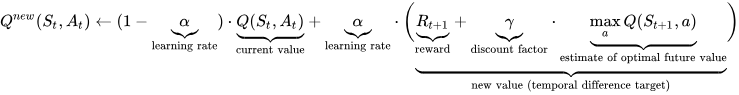<br>Image from https://en.wikipedia.org/wiki/Q-learning<br><br>
<ins>Definitions of each hyperparameters:<ins>

1. **epsilon** = Exploration rate of agent during training, which intially start at 1 representing random action. It is gradually decayed over time to make trained decisions.<br><br>
2. **epsilon_min** = Minimum value of epsilon, to ensure that the agent does not stop exploring entirely, even as it becomes more confident in its exploration.<br><br>
3. **epsilon_decay** = Rate which opsilon decreases over time, exploring less over time.<br><br>
4. **learning_rate** = α, determins the step size at which the agent updates its Q values dueing the learning process. A smaller learning rate can lead to slower learning but may converge a better solution, while a larger learning rate can lead to faster learning but may not converge to an optimal solution.<br><br>
5. **discount** = γ, discount factor quantifies the extent to which the agent values immediate rewards compared to future rewards.<br><br>
6. **EPISODES** = Number of episodes agent will play during the learning process.<br><br>
7. **actions** = [0,1]: There are two valid discrete actions: 0 for pushing the the left and 1 for pushing to the right.<br><br>
8. **observation** = Array with values corresponding to cart position, velocity and pole angle, angular velocity of a state.<br><br>
9. **window_size** = Size of the window used to discretize the observation space.<br><br>
10. **reward_arr** = List to store the reward obtained by the agent at each episode during training.

In [ ]:
#Defining hyperparameters

epsilon = 1
epsilon_min = 0.01
epsilon_decay = (epsilon - epsilon_min)/20000

learning_rate = 0.2
discount = 1
EPISODES = 20000
actions = [0,1]

observation = [50,50,50,50]
window_size = np.array([0.2,0.2,0.02,0.2])
reward_arr = []

## 1.2 Create the Q-Table

In [ ]:
#Create Q table

q_table = np.zeros((observation + [env.action_space.n]))
q_table.shape

(50, 50, 50, 50, 2)

np.zeros: This utilises the zeros function from the numpy library. This function creates a new array filled with zeroes.

The code creates a new numpy array filled with zeroes, where the dimensions of the array are determined by the size of the observation space and the number of actions possible in the environment

## 1.3 Get Discrete State

The observation contains 4 continuous variables corresponding to cart position, cart velocity, pole angle and pole angular velocity. These continuous values need to be converted to discrete to store their values into the Q-table.

Steps taken to convert from continuous to discrete:
<br>
1. Divides each element in state by the corresponding value in window_size array.
<br>
2. Adds a constant value to each element. The offset is used to shift normalised values into a specific range suitable for discretisation.
<br>
3. astype(int) converts the result from float to integer values.
<br>
4. Returns a tuple containing the integer values

In [ ]:
#Get discrete state

def get_discrete_state(state):
  result = state/window_size + np.array([25,10,21,10])
  return tuple(result.astype(int))

print(get_discrete_state(env.step(0)[0]))

(25, 9, 22, 11)


## 1.4 Q-Learning Process

In [ ]:
def QLearning(agent, num_episodes, learning_rate, epsilon, epsilon_decay, discount, q_table):
  # Reward array to store rewards for each episode
  reward_arr = []
  total_reward = 0
  for episode in range(num_episodes):
    #Reset the environment and get a new state
    current_state = get_discrete_state(agent.reset()[0])
    done = False
    # Variables to keep track of each episode
    episode_length = 0
    episode_reward = 0

    # Loop until episodes are complete or a terminal state is reached
    while not done:
      # Determine the action to take with epsilon greedy policy. Initially, higher epsilon == take more random actions
      if np.random.random() < epsilon:
        action = np.random.randint(0, env.action_space.n)
      else:
        action = np.argmax(q_table[current_state])

      # Obtain the state based on the action taken
      new_observation = agent.step(action)
      new_state = new_observation[0]
      new_reward = new_observation[1]
      done = new_observation[2]

      # Increases number of repitition in episodes. Perform summation of accumulated rewards
      episode_length += 1
      episode_reward += new_reward

      # Discretize the state and find maximum Q-value for the new state
      new_discrete_state = get_discrete_state(new_state)
      max_q = np.max(q_table[new_discrete_state])
      current_q = q_table[current_state + (action,)]

      if done:
        if episode_length > 195:
          reward = 1
        else:
          reward = -1 # Negative reward for fewer than 195 episodes
      else:
        reward = 0.1 # Encourage agent to explore more

      # Updating Q-table based on Q-learning update formula
      new_q = (1 - learning_rate) * current_q + learning_rate * (reward + discount * max_q)
      q_table[current_state + (action,)] = new_q

      # Update current state to the new state
      current_state = new_discrete_state

    # Tracking total reward
    total_reward += episode_reward
    reward_arr.append(episode_reward)

    # If total reward is satisfactory, the agent will take fewer random actions
    if total_reward >= 195 and epsilon > 0.01:
      epsilon -= epsilon_decay

    # Every 100 episodes, the episode length, epsilon value and mean reward is printed
    if episode % 100 == 0:
      print("Episode: " + str(episode))
      print("Episode length: " + str(episode_length))
      print("Epsilon: " + str(epsilon))
      print("Mean Reward: " + str(total_reward/100))

      total_reward = 0 # Reset total reward for each episode

  # Closing the environment and returning the trained Q-table and reward_arr
  agent.close()
  return q_table, reward_arr

# Running the trained agent based on initialised parameters
q_table, reward_arr = QLearning(env, EPISODES, learning_rate, epsilon, epsilon_decay, discount, q_table)

Episode: 0
Episode length: 37
Epsilon: 1
Mean Reward: 0.37
Episode: 100
Episode length: 10
Epsilon: 0.9953469999999967
Mean Reward: 22.89
Episode: 200
Episode length: 43
Epsilon: 0.9907929999999934
Mean Reward: 24.82
Episode: 300
Episode length: 22
Epsilon: 0.9862884999999901
Mean Reward: 21.78
Episode: 400
Episode length: 18
Epsilon: 0.9816354999999868
Mean Reward: 23.8
Episode: 500
Episode length: 14
Epsilon: 0.9771309999999835
Mean Reward: 23.48
Episode: 600
Episode length: 16
Epsilon: 0.9726759999999803
Mean Reward: 23.82
Episode: 700
Episode length: 10
Epsilon: 0.9681219999999771
Mean Reward: 22.39
Episode: 800
Episode length: 18
Epsilon: 0.9635184999999737
Mean Reward: 22.73
Episode: 900
Episode length: 22
Epsilon: 0.9587664999999703
Mean Reward: 23.0
Episode: 1000
Episode length: 32
Epsilon: 0.954212499999967
Mean Reward: 20.96
Episode: 1100
Episode length: 23
Epsilon: 0.9497079999999638
Mean Reward: 24.12
Episode: 1200
Episode length: 17
Epsilon: 0.9451539999999605
Mean Reward:

## 1.5 Sample a Random State

From here, we will sample a random state from the cart pole environment through observation[0]. We will input the state into the agent, which will output a chosen action.

In [ ]:
#Resetting the env and obtaining the initial observation
observation = env.reset()

#Print observation of the first element
print("Observation:" , observation[0] )

#Converting the continuous observation to a discrete state
discrete_state = get_discrete_state(observation[0])

#Using the Q-table to choose the best action for the current state
action = np.argmax(q_table[discrete_state])

#Get discrete state
print(get_discrete_state(env.step(0)[0]))

#Get chosen action
print("Chosen Action:", action)

Observation: 7.013793e-06
(24, 9, 19, 11)
Chosen Action: 0


# Task 2: Effectiveness of the RL Agent

We will run reset the environment at the start of each episode, and run for a total of 100 episodes. We will calculate the average of reward_arr2 which is an array to store reward of each episode, hence average of it will
determine the average reward of all episodes. For the RL agent to be effective, the avergae reward should be larger than 195.

In [ ]:
#Array which has 100 indexes, due to 100 episodes, each element represents the total reward of each episode.
reward_arr2 = []

#Running 100 episodes
for episode in range(100):

  #Reset environment at the beigging of each episode
  discrete_state = get_discrete_state(env.reset()[0])
  done = False

  #Initialise reward to be 0 at the start of the episode
  episode_reward = 0

  while not done:
    #Using the Q-table to choose the best action for the current state
    action = np.argmax(q_table[discrete_state])

    #Update variables
    new_environment = env.step(action)
    new_state = new_environment[0]
    reward = new_environment[1]
    done = new_environment[2]

    #Update reward within the episode
    episode_reward += reward

    #Ends episode if it reaches 500
    if episode_reward > 500:
      done = True

    #Updates discrete state
    new_discrete_state = get_discrete_state(new_state)
    discrete_state = new_discrete_state

    if done:
      observation = env.reset()
      discrete_state = get_discrete_state(observation[0])

  #Append reward of end of an episode into the reward_arr2 array
  reward_arr2.append(episode_reward)

env.close()

Average cumulative reward: 430.88
Is my agent good enough? True


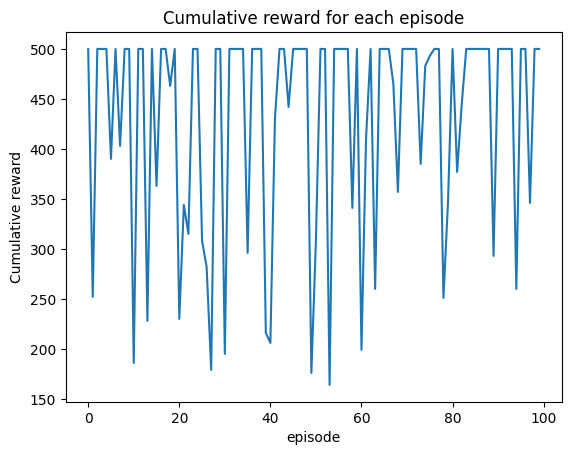

In [ ]:
print("Average cumulative reward: " + str(np.mean(reward_arr2)))
print("Is my agent good enough? " + str(np.mean(reward_arr2) > 195))
plt.plot(reward_arr2)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Since the average cumulative reward is more than 195, the agent is good enough.

# Task 3: Render One Episode Played by the Agent


We will be testing our trained agent by rendering 1 episode to see whether the pole is able to balance on the cart for a period of time.

In [ ]:
#Creating instance of RecordVideo
env = RecordVideo(gym.make("CartPole-v1"), "./video" )

#Reset env and obtain initial observation, discrete state and intialise reward
observation = env.reset()
discrete_state = get_discrete_state(observation[0])

#Initialise reward to be 0 at the start of the episode
episode_reward = 0

done = False
while not done:

  #Determining action to take based on q_table values and select action with highest value
  action = np.argmax(q_table[discrete_state])

  #take chosen action in env and obtain new state, reward, and done flag
  new_env = env.step(action)
  new_state = new_env[0]
  reward = new_env[1]
  done = new_env[2]

  #Update reward within the episode
  episode_reward += reward

  #Updates discrete state
  new_discrete_state = get_discrete_state(new_state)
  discrete_state = new_discrete_state

env.close()
show_video()
print(episode_reward)

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


500.0


# Conclusion

We have trained our agent using Q-learning algorithm and used the following hyperparameters: <br>

learning rate: 0.2 <br>
discount factor: 1 <br>
number of episodes used for training: 20000 <br>

The hyperparameter values were selected after performing trials with different combinations of values and we fine-tuned these parameters to train the most effective agent.

We were able to able to achieve an average cumulative reward greater than 195 over the course of 100 episodes. This indicates that our agent has learnt an effective strategy of balancing the cartpole. <br>

We were also able to render one episode of our trained agent, demonstrating that our agent is able to perform well in a real scenario. By using a Q-table and selected hyperparameters, we created an effective reinforcement learning model that solves the cartpole problem. <br>
